# density-9999不够大，无法体现差异性

要点梳理：
- 剔除云层遮挡和数据缺失的情况

拖山的经度和纬度是(120.14,31.406)，兰山嘴的经度和纬度是(119.89,31.212)。我需要分析这2个点位逐日的叶绿素a浓度，请你修改下面的代码。如果受到云层影响导致数据缺失，请你用NAN代替。

创新点在于，将云层覆盖的区域设置为999999，这样在后续处理中可以很容易地识别出这些区域。

https://engine-aiearth.aliyun.com/docs/page/api?d=07f36f#heading-22

https://engine-aiearth.aliyun.com/?spm=a2cvf.28031243.0.0.5dc743d42pbV5o#/utility/auth-token

In [1]:
import aie

aie.Authenticate(token='5bec0c94255e4a9bf785dd9bc18cd87b')
aie.Initialize()

计算资源初始化中，请等待...
计算资源初始化完成.


In [2]:
import geopandas as gpd

In [3]:
# 读取shp文件
shapefile_path = '/root/Download/Modis-algae-aliyun/local-data/taihu.shp'
gdf = gpd.read_file(shapefile_path)

# 假设shp文件中只有一个几何对象，取第一个
geometry = gdf.geometry.iloc[0]
print(geometry)
# 输出((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, ...

# 将geopandas的geometry对象转换为ee.Geometry
coords = list(geometry.exterior.coords)
flattened_coords = [coord for point in coords for coord in point]
taihu = aie.Geometry.Polygon(flattened_coords)
# 构造Polygon。输入参数支持GeoJSON 'Polygon'类型格式的坐标点集，
# 同时也支持包含偶数个数字的一维List，例如aie.Geometry.Polygon([aLng, aLat, bLng, bLat, ...])。
# 需注意，输入的坐标点将以EPSG:4326坐标系进行解析。

# 打印ee.Geometry对象以验证
print(taihu)

POLYGON ((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, 120.00611934273043 31.40820067954559, 120.0213482061359 31.420557311454473, 120.02780893606551 31.42562749019076, 120.03023170978913 31.42966374717613, 120.0274051404449 31.43596389857637, 120.02025218945138 31.447873965243872, 120.00888822698595 31.45166321445573, 120.01067646473432 31.455403102339847, 120.01448368058568 31.46224277412878, 120.01806015608244 31.467556706624215, 120.02342486932757 31.473017934057427, 120.02827041677476 31.47729813281918, 120.02902032292732 31.479561147303205, 120.03525031250228 31.481725718642263, 120.03871141782174 31.48452974796941, 120.04223020822982 31.48275879185581, 120.04678733023371 31.479659537995836, 120.05734370145801 31.476461787529658, 120.06017027080222 31.47651098451827, 120.06380443138762 31.471541958062947, 120.06276609979179 31.468442332717288, 120.06345832085567 31.46578542930369, 120.06703479635243 31.4656870240255, 120.07078432711515 31.46052060

# 计算完整的7月份

你这个逻辑还是有问题，请你用伪代码的方式，提供一个代码的逻辑框架，please think by chain-of-thought：


我需要你同步输出modis反演的藻密度和lanshanzui.csv'中的藻密度，使得二者之间的差距尽可能小。由于lanshanzui.csv'中的藻密度一天会产生6个值，因此lanshanzui.csv'中的藻密度将采用置信区间的形式，modis反演的藻密度将与“lanshanzui.csv'中的藻密度将采用置信区间”进行比较

请你分析并修改这段代码，我的顾虑是："""这段代码好像是通过2022年7月逐日的计算值逐步优化参数，应该根据遥感影像的sample的完整的2022年7月的结果一起计算？输出一个最终的优化参数？"""

需要你注意如下2种情况将不作为参数优化的计算依据：
- MODIS遥感影像中藻密度为9999.0，也就是云层遮挡的情况
- df['density']中数据缺失的情况。


## demo-1.0版本-计算失败

/tmp/ipykernel_911/1916508253.py:55: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1916508253.py:55: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1916508253.py:55: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1916508253.py:55: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1916508253.py:55: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1916508253.py:55: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1916508253.py:55: UserWarning: Glyph 21450 (\N{CJK UNIFIED IDEOGRAPH-53CA}) missing from current font.
  plt.tight_layout()

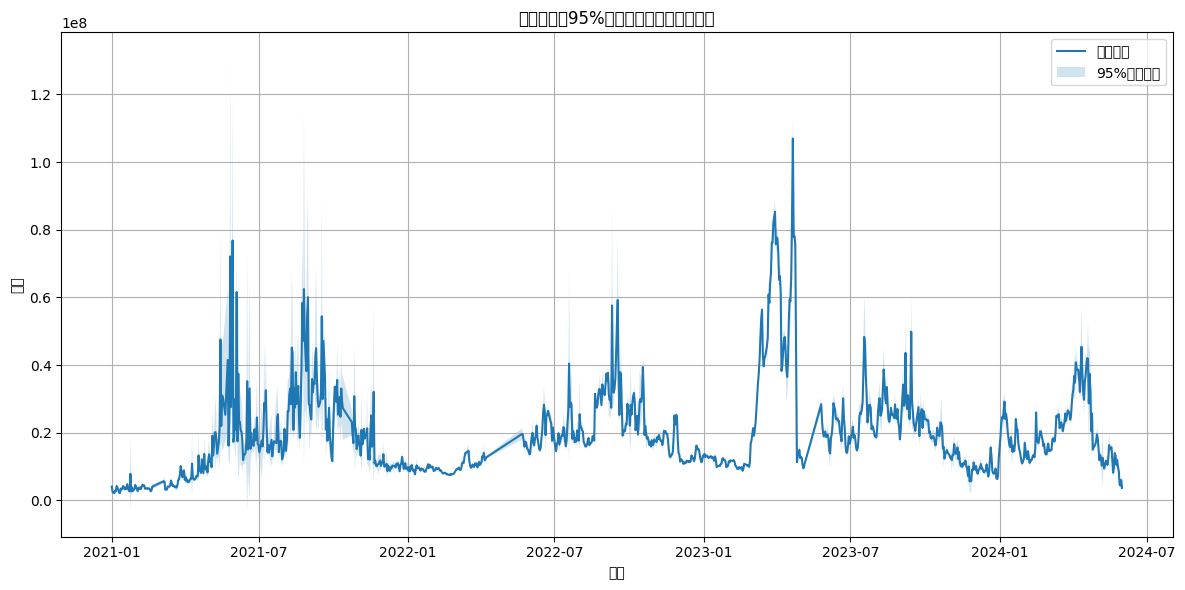

In [4]:
import datetime
import csv
import aie
import pandas as pd
import numpy as np
import chardet
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 步骤1: 数据准备
csv_file = '/root/Download/Modis-algae-aliyun/aie-taihu/00-tuoshan.csv'

# 检测文件编码
with open(csv_file, 'rb') as f:
    result = chardet.detect(f.read())

# 使用探测到的编码读取文件
df = pd.read_csv(csv_file, encoding=result['encoding'])

# 将日期列转换为日期时间格式
df['date'] = pd.to_datetime(df['date'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 对密度列进行线性插值
df['density'] = df['density'].interpolate(method='linear')

# 按日期分组并计算每日的统计数据
daily_stats = df['density'].resample('D').agg(['mean', 'std', 'count'])

# 计算95%置信区间
confidence_interval = 1.96 * daily_stats['std'] / np.sqrt(daily_stats['count'])

# 计算置信区间的上下限
daily_stats['lower_ci'] = daily_stats['mean'] - confidence_interval
daily_stats['upper_ci'] = daily_stats['mean'] + confidence_interval

# 对平均值和置信区间上下限进行线性插值
daily_stats_interpolated = daily_stats.interpolate(method='linear')

# 绘制密度和置信区间
plt.figure(figsize=(12, 6))
plt.plot(daily_stats_interpolated.index, daily_stats_interpolated['mean'], label='平均密度')
plt.fill_between(daily_stats_interpolated.index, daily_stats_interpolated['lower_ci'], daily_stats_interpolated['upper_ci'], alpha=0.2, label='95%置信区间')
plt.xlabel('日期')
plt.ylabel('密度')
plt.title('藻类密度及95%置信区间（线性插值后）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 收集MODIS所有有效数据

In [5]:
roi = aie.Geometry.BBox(120.14,31.406,120.15,31.41)

In [6]:





# def mask_clouds(image):
#     qa = image.select('state_1km')
#     cloud_bit_mask = 1 << 10
#     mask = qa.bitwiseAnd(aie.Image.constant(cloud_bit_mask))
#     return mask

## 加载已保存的数据版本

In [7]:

# 
# from requests.exceptions import ReadTimeout
# import pickle
# import datetime

# # 加载已保存的数据（如果存在）
# try:
#     current_date = datetime.date.today()
#     filename = f'saved_data_{current_date.strftime("%Y%m%d")}.pkl'
#     with open(filename, 'rb') as f:
#         saved_data = pickle.load(f)
#     valid_features = saved_data['valid_features']
#     valid_density_mean = saved_data['valid_density_mean']
#     valid_density_lower = saved_data['valid_density_lower']
#     valid_density_upper = saved_data['valid_density_upper']
#     start_date = saved_data['start_date']
#     print(f"已加载保存的数据 {filename}，从", start_date, "继续")
# except FileNotFoundError:
#     print("未找到保存的数据，从头开始")

## valid_features线性插值



In [8]:



from aiearth.core.error.aie_error import AIEError
import time
from http.client import RemoteDisconnected
from requests.exceptions import ConnectionError
from requests.exceptions import ReadTimeout
from aiearth.core.error.aie_error import AIEError



valid_features = {}
valid_density_mean = []
valid_density_lower = []
valid_density_upper = []
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2024, 5, 31)
delta = datetime.timedelta(days=1)
valid_dates = []

def calculate_composite_indices(par_values):
    # 1. 日累积PAR (DAPAR)
    dapar = sum(par_values.values())
    
    # 2. PAR日变化率 (PDVI)
    pdvi = max(par_values.values()) / (min(par_values.values()) + 1e-6)  # 避免除以零
    
    # 3. 上午PAR积累率 (MPAR)
    morning_par = [par_values['GMT_0000_PAR'], par_values['GMT_0300_PAR'], par_values['GMT_0600_PAR'], par_values['GMT_0900_PAR']]
    mpar = (max(morning_par) - min(morning_par)) / 9  # 9小时
    
    # 4. 下午PAR衰减率 (APAR)
    afternoon_par = [par_values['GMT_1200_PAR'], par_values['GMT_1500_PAR'], par_values['GMT_1800_PAR'], par_values['GMT_2100_PAR']]
    apar = (max(afternoon_par) - min(afternoon_par)) / 9  # 9小时
    
    # 5. PAR峰值持续指数 (PPDI)
    avg_par = sum(par_values.values()) / 8
    ppdi = sum(1 for v in par_values.values() if v > avg_par) / 8
    
    # 6. PAR不对称性指数 (PAI)
    morning_sum = sum(morning_par)
    afternoon_sum = sum(afternoon_par)
    pai = (afternoon_sum - morning_sum) / (afternoon_sum + morning_sum + 1e-6)
    
    return dapar, pdvi, mpar, apar, ppdi, pai









# 在文件开头添加导入语句
import pickle

# 保存当前进度
def save_progress(date_str, valid_features, valid_density_mean, valid_density_lower, valid_density_upper, valid_dates):
    progress = {
        'last_date': date_str,
        'valid_features': valid_features,
        'valid_density_mean': valid_density_mean,
        'valid_density_lower': valid_density_lower, 
        'valid_density_upper': valid_density_upper,
        'valid_dates': valid_dates
    }
    with open('progress.pkl', 'wb') as f:
        pickle.dump(progress, f)
    print(f"进度已保存到 progress.pkl, 最后处理日期: {date_str}")

# 加载上次进度
def load_progress():
    try:
        with open('progress.pkl', 'rb') as f:
            progress = pickle.load(f)
            print(f"已加载上次进度,从 {progress['last_date']} 继续")
            return progress
    except FileNotFoundError:
        print("未找到进度文件,从头开始处理")
        return None

# 检查是否存在上次进度
progress = load_progress()
if progress:
    # 从上次中断的地方继续
    last_date = datetime.datetime.strptime(progress['last_date'], "%Y_%m_%d").date()
    start_date = last_date + datetime.timedelta(days=1)
    valid_features = progress['valid_features']
    valid_density_mean = progress['valid_density_mean']
    valid_density_lower = progress['valid_density_lower']
    valid_density_upper = progress['valid_density_upper'] 
    valid_dates = progress['valid_dates']

# 每处理100天保存一次进度
days_processed = 0










while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    retry_count = 0
    while retry_count < 10:
        try:
            img = aie.Image(f'MODIS_MCD18C2_061_{date_str}')\
                     .select(['GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 
                              'GMT_1200_PAR', 'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR'])
            
            current_date = pd.to_datetime(start_date)
            if current_date in daily_stats_interpolated.index:
                mean_density = daily_stats_interpolated.loc[current_date, 'mean']
                lower_ci = daily_stats_interpolated.loc[current_date, 'lower_ci']
                upper_ci = daily_stats_interpolated.loc[current_date, 'upper_ci']
                
                par_values = {}
                for band in ['GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 
                             'GMT_1200_PAR', 'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR']:
                    par_values[band] = img.select(band).sample(roi, 100, 1, 0, True).aggregate_array(band).getInfo()
                
                valid_indices = [i for i in range(len(par_values['GMT_0000_PAR'])) if all(0 <= par_values[band][i] <= 700 for band in par_values)]
                
                if valid_indices:
                    for i in valid_indices:
                        daily_par = {band: par_values[band][i] for band in par_values}
                        dapar, pdvi, mpar, apar, ppdi, pai = calculate_composite_indices(daily_par)
                        
                        for band in par_values.keys():
                            if band not in valid_features:
                                valid_features[band] = []
                            valid_features[band].append(daily_par[band])
                        
                        if 'DAPAR' not in valid_features:
                            valid_features['DAPAR'] = []
                        valid_features['DAPAR'].append(dapar)
                        
                        if 'PDVI' not in valid_features:
                            valid_features['PDVI'] = []
                        valid_features['PDVI'].append(pdvi)
                        
                        if 'MPAR' not in valid_features:
                            valid_features['MPAR'] = []
                        valid_features['MPAR'].append(mpar)
                        
                        if 'APAR' not in valid_features:
                            valid_features['APAR'] = []
                        valid_features['APAR'].append(apar)
                        
                        if 'PPDI' not in valid_features:
                            valid_features['PPDI'] = []
                        valid_features['PPDI'].append(ppdi)
                        
                        if 'PAI' not in valid_features:
                            valid_features['PAI'] = []
                        valid_features['PAI'].append(pai)
                    
                    valid_density_mean.extend([mean_density] * len(valid_indices))
                    valid_density_lower.extend([lower_ci] * len(valid_indices))
                    valid_density_upper.extend([upper_ci] * len(valid_indices))
                    valid_dates.extend([current_date] * len(valid_indices))
                    
                    # print(f"成功处理日期 {date_str} 的数据，有效样本数: {len(valid_indices)}")
                else:
                    print(f"日期 {date_str} 没有有效的PAR值")
            else:
                print(f"日期 {date_str} 在插值数据中不存在")
            break  # 如果成功处理数据，跳出重试循环
        except (AIEError, RemoteDisconnected, ConnectionError, ReadTimeout) as e:
            print(f"处理日期 {date_str} 的数据时出错 (尝试 {retry_count + 1}/10): {str(e)}")
            retry_count += 1
            if retry_count < 10:
                time.sleep(30)  # 增加等待时间到30秒后重试
                continue  # 继续重试
            elif retry_count == 10:
                print(f"无法处理日期 {date_str} 的数据，已达到最大重试次数")
                break  # 跳出重试循环
    
    start_date += delta
    
    days_processed += 1
    
    # 每处理100天保存一次进度
    if days_processed % 100 == 0:
        save_progress(date_str, valid_features, valid_density_mean, valid_density_lower, valid_density_upper, valid_dates)

未找到进度文件,从头开始处理
进度已保存到 progress.pkl, 最后处理日期: 2021_04_10
处理日期 2021_04_14 的数据时出错 (尝试 1/10): 系统未知异常. {"taskId": "5b9e65ac-9a04-11ef-9faa-00155d97dbfc"}
处理日期 2021_04_27 的数据时出错 (尝试 1/10): 系统未知异常. {"taskId": "83f1d27c-9a05-11ef-9faa-00155d97dbfc"}
进度已保存到 progress.pkl, 最后处理日期: 2021_07_19
处理日期 2021_08_09 的数据时出错 (尝试 1/10): 系统未知异常. {"taskId": "22075cfe-9a0e-11ef-9faa-00155d97dbfc"}
处理日期 2021_08_09 的数据时出错 (尝试 2/10): [AIEError]: 22820932, 372fd8ae 正在调整计算资源，请稍等片刻重新执行aie.Initialize()进行初始化. {"taskId": "372fd8ae-9a0e-11ef-9faa-00155d97dbfc"}
处理日期 2021_10_24 的数据时出错 (尝试 1/10): 系统未知异常. {"taskId": "6d3dae8e-9a14-11ef-9faa-00155d97dbfc"}
进度已保存到 progress.pkl, 最后处理日期: 2021_10_27
处理日期 2021_11_26 的数据时出错 (尝试 1/10): [AIEError]: 22820932, 3b40ec22 正在调整计算资源，请稍等片刻重新执行aie.Initialize()进行初始化. {"taskId": "3b40ec22-9a17-11ef-9faa-00155d97dbfc"}
处理日期 2021_11_26 的数据时出错 (尝试 2/10): [AIEError]: 22820932, 4d84b936 正在调整计算资源，请稍等片刻重新执行aie.Initialize()进行初始化. {"taskId": "4d84b936-9a17-11ef-9faa-00155d97dbfc"}
处理日期 2021_11_26 的数据时出错

In [9]:
# # 在文件开头添加导入语句
# import pickle

# # 保存当前进度
# def save_progress(date_str, valid_features, valid_density_mean, valid_density_lower, valid_density_upper, valid_dates):
#     progress = {
#         'last_date': date_str,
#         'valid_features': valid_features,
#         'valid_density_mean': valid_density_mean,
#         'valid_density_lower': valid_density_lower, 
#         'valid_density_upper': valid_density_upper,
#         'valid_dates': valid_dates
#     }
#     with open('progress.pkl', 'wb') as f:
#         pickle.dump(progress, f)
#     print(f"进度已保存到 progress.pkl, 最后处理日期: {date_str}")

# # 加载上次进度
# def load_progress():
#     try:
#         with open('progress.pkl', 'rb') as f:
#             progress = pickle.load(f)
#             print(f"已加载上次进度,从 {progress['last_date']} 继续")
#             return progress
#     except FileNotFoundError:
#         print("未找到进度文件,从头开始处理")
#         return None

# # 检查是否存在上次进度
# progress = load_progress()
# if progress:
#     # 从上次中断的地方继续
#     last_date = datetime.datetime.strptime(progress['last_date'], "%Y_%m_%d").date()
#     start_date = last_date + datetime.timedelta(days=1)
#     valid_features = progress['valid_features']
#     valid_density_mean = progress['valid_density_mean']
#     valid_density_lower = progress['valid_density_lower']
#     valid_density_upper = progress['valid_density_upper'] 
#     valid_dates = progress['valid_dates']

# # 每处理100天保存一次进度
# days_processed = 0
# while start_date <= end_date:
#     date_str = start_date.strftime("%Y_%m_%d")
#     retry_count = 0
#     while retry_count < 10:
#         try:
#             img = aie.Image(f'MODIS_MCD18C2_061_{date_str}')\
#                      .select(['GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 
#                               'GMT_1200_PAR', 'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR'])
            
#             current_date = pd.to_datetime(start_date)
#             if current_date in daily_stats_interpolated.index:
#                 mean_density = daily_stats_interpolated.loc[current_date, 'mean']
#                 lower_ci = daily_stats_interpolated.loc[current_date, 'lower_ci']
#                 upper_ci = daily_stats_interpolated.loc[current_date, 'upper_ci']
                
#                 par_values = {}
#                 for band in ['GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 
#                              'GMT_1200_PAR', 'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR']:
#                     par_values[band] = img.select(band).sample(roi, 100, 1, 0, True).aggregate_array(band).getInfo()
                
#                 valid_indices = [i for i in range(len(par_values['GMT_0000_PAR'])) if all(0 <= par_values[band][i] <= 700 for band in par_values)]
                
#                 if valid_indices:
#                     for i in valid_indices:
#                         daily_par = {band: par_values[band][i] for band in par_values}
#                         dapar, pdvi, mpar, apar, ppdi, pai = calculate_composite_indices(daily_par)
                        
#                         for band in par_values.keys():
#                             if band not in valid_features:
#                                 valid_features[band] = []
#                             valid_features[band].append(daily_par[band])
                        
#                         if 'DAPAR' not in valid_features:
#                             valid_features['DAPAR'] = []
#                         valid_features['DAPAR'].append(dapar)
                        
#                         if 'PDVI' not in valid_features:
#                             valid_features['PDVI'] = []
#                         valid_features['PDVI'].append(pdvi)
                        
#                         if 'MPAR' not in valid_features:
#                             valid_features['MPAR'] = []
#                         valid_features['MPAR'].append(mpar)
                        
#                         if 'APAR' not in valid_features:
#                             valid_features['APAR'] = []
#                         valid_features['APAR'].append(apar)
                        
#                         if 'PPDI' not in valid_features:
#                             valid_features['PPDI'] = []
#                         valid_features['PPDI'].append(ppdi)
                        
#                         if 'PAI' not in valid_features:
#                             valid_features['PAI'] = []
#                         valid_features['PAI'].append(pai)
                    
#                     valid_density_mean.extend([mean_density] * len(valid_indices))
#                     valid_density_lower.extend([lower_ci] * len(valid_indices))
#                     valid_density_upper.extend([upper_ci] * len(valid_indices))
#                     valid_dates.extend([current_date] * len(valid_indices))
                    
#                     # print(f"成功处理日期 {date_str} 的数据，有效样本数: {len(valid_indices)}")
#                 else:
#                     print(f"日期 {date_str} 没有有效的PAR值")
#             else:
#                 print(f"日期 {date_str} 在插值数据中不存在")
#             break  # 如果成功处理数据，跳出重试循环
#         except (AIEError, RemoteDisconnected, ConnectionError, ReadTimeout) as e:
#             print(f"处理日期 {date_str} 的数据时出错 (尝试 {retry_count + 1}/10): {str(e)}")
#             retry_count += 1
#             if retry_count < 10:
#                 time.sleep(30)  # 增加等待时间到30秒后重试
#                 continue  # 继续重试
#             elif retry_count == 10:
#                 print(f"无法处理日期 {date_str} 的数据，已达到最大重试次数")
#                 break  # 跳出重试循环
    
#     start_date += delta
#     days_processed += 1
    
#     # 每处理100天保存一次进度
#     if days_processed % 100 == 0:
#         save_progress(date_str, valid_features, valid_density_mean, valid_density_lower, valid_density_upper, valid_dates)

In [13]:
# 将结果保存到CSV，计算并打印缺失值的数量和比例
if valid_features:
    results_df = pd.DataFrame(valid_features)
    results_df['density_mean'] = valid_density_mean
    results_df['density_lower'] = valid_density_lower
    results_df['density_upper'] = valid_density_upper
    results_df['date'] = valid_dates

    # 计算缺失日期
    date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    missing_dates = date_range.difference(results_df['date'])
    missing_count = len(missing_dates)
    total_days = (max(valid_dates) - min(valid_dates)).days + 1
    missing_percentage = 100 * missing_count / total_days
    
    print(f"缺失日期数量: {missing_count}")
    print(f"缺失日期比例: {missing_percentage:.2f}%")
    print("缺失日期:")
    print(missing_dates)

    # 生成包含日期和遥感影像名称的文件名
    current_date = datetime.datetime.now().strftime("%Y%m%d")
    filename = f'特征和密度结果_MODIS_MCD18C2_061_{current_date}_tuoshan.csv'
    
    results_df.to_csv(filename, index=False)
    print(f"\n结果已保存到 '{filename}'")
else:
    print("无有效数据可保存")



缺失日期数量: 8
缺失日期比例: 0.64%
缺失日期:
DatetimeIndex(['2023-06-02', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-07', '2024-02-08', '2024-02-10'],
              dtype='datetime64[ns]', freq=None)

结果已保存到 '特征和密度结果_MODIS_MCD18C2_061_20241104_tuoshan.csv'


In [14]:
# 生成包含缺失日期的完整数据集并进行线性插值填充
if valid_features:
    # 创建完整的日期范围
    full_date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    
    # 将现有数据转换为以日期为索引的DataFrame
    full_df = results_df.set_index('date')
    
    # 重新索引到完整的日期范围，这将自动为缺失的日期创建NaN值
    full_df = full_df.reindex(full_date_range)
    
    # 对所有列进行线性插值
    interpolated_df = full_df.interpolate(method='linear')
    
    # 重置索引，使日期成为一个列
    interpolated_df = interpolated_df.reset_index()
    interpolated_df = interpolated_df.rename(columns={'index': 'date'})
    
    # 保存插值后的结果到新的CSV文件
    interpolated_filename = f'特征和密度结果_MODIS_MCD18C2_061_{current_date}_插值填充_tuoshan.csv'
    interpolated_df.to_csv(interpolated_filename, index=False)
    print(f"\n插值填充后的结果已保存到 '{interpolated_filename}'")
    
    # 输出插值填充后的数据信息
    print(f"\n插值填充后的数据行数: {len(interpolated_df)}")
    print(f"插值填充前的数据行数: {len(results_df)}")
    print(f"填充的行数: {len(interpolated_df) - len(results_df)}")
else:
    print("无有效数据可进行插值填充")



插值填充后的结果已保存到 '特征和密度结果_MODIS_MCD18C2_061_20241104_插值填充_tuoshan.csv'

插值填充后的数据行数: 1247
插值填充前的数据行数: 1239
填充的行数: 8


当前工作目录: /root/Download/Modis-algae-aliyun/aie-taihu
当前目录下的文件:
特征和密度结果_MODIS_MOD09GA_061_20241029_插值填充.csv
03-inversion-taihu-1021-density-moremoremoredays-LSTM.ipynb
05-merge-mod-mcd-RF.ipynb
03-LSTM-1024-predict.ipynb
02-inversion-taihu-1016-density-runone.ipynb
05-merge-mod-mcd-tcn-basic.ipynb
01-test-taihu.ipynb
01-test-taihu-1016-chla.ipynb
03-inversion-taihu-1019-density-moredays-RF .ipynb
00-tuoshan.csv
特征和密度结果_MODIS_MCD18C2_061_20241027_插值填充.csv
04-LSTM-lanzhanzui++1025-predict.ipynb
05-merge-mod-mcd-tcn-basic-better.ipynb
06-merge-mod-mcd-tcn-basic-1031-keyfeature-02LSTM.ipynb
03-inversion-taihu-1019-density-moremoredays-RF.ipynb
00-lanshanzui.csv
03-LSTM-1024-read-train.ipynb
07-LSTM-tuoshan+MCD18C2+1102-read.ipynb
07-LSTM-lanshanzui+MCD18C2+1027-read.ipynb
progress.pkl
04-LSTM-lanzhanzui++1025-read-train.ipynb
02-inversion-taihu-1016-density-runall-78.ipynb
特征和密度结果_MODIS_MCD18C2_061_20241104_tuoshan.csv
06-merge-mod-mcd-tcn-basic-1031-relation.ipynb
07-LSTM-tuoshan+MOD09GA+11

/tmp/ipykernel_911/1304211996.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_911/1304211996.py:46: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1304211996.py:46: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1304211996.py:46: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1304211996.py:46: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_911/1304211996.py:46: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-

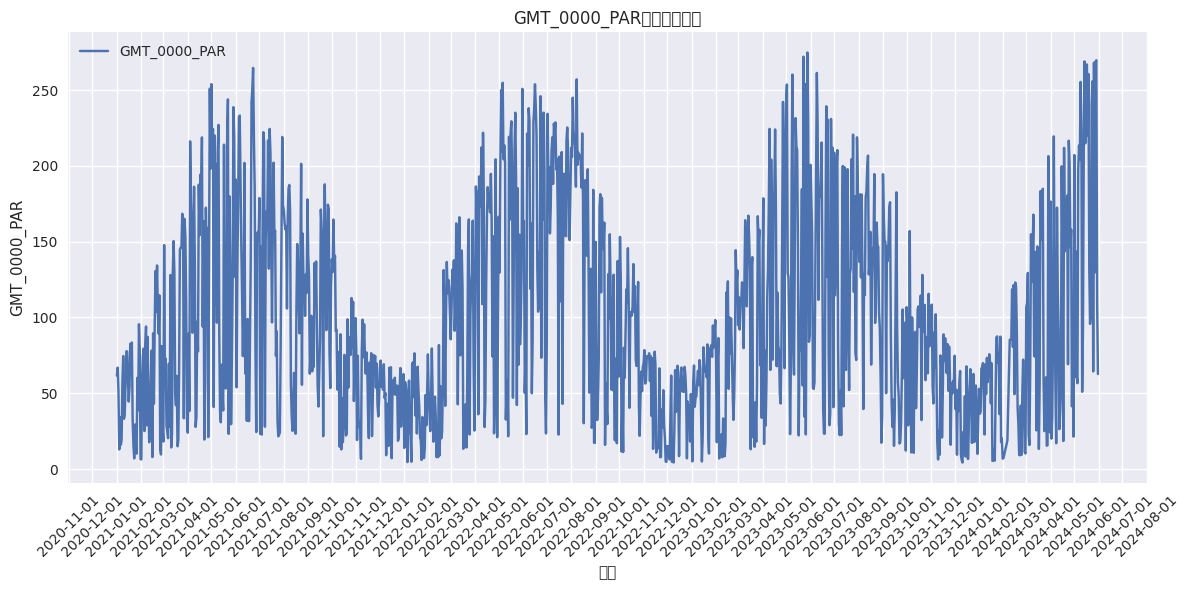

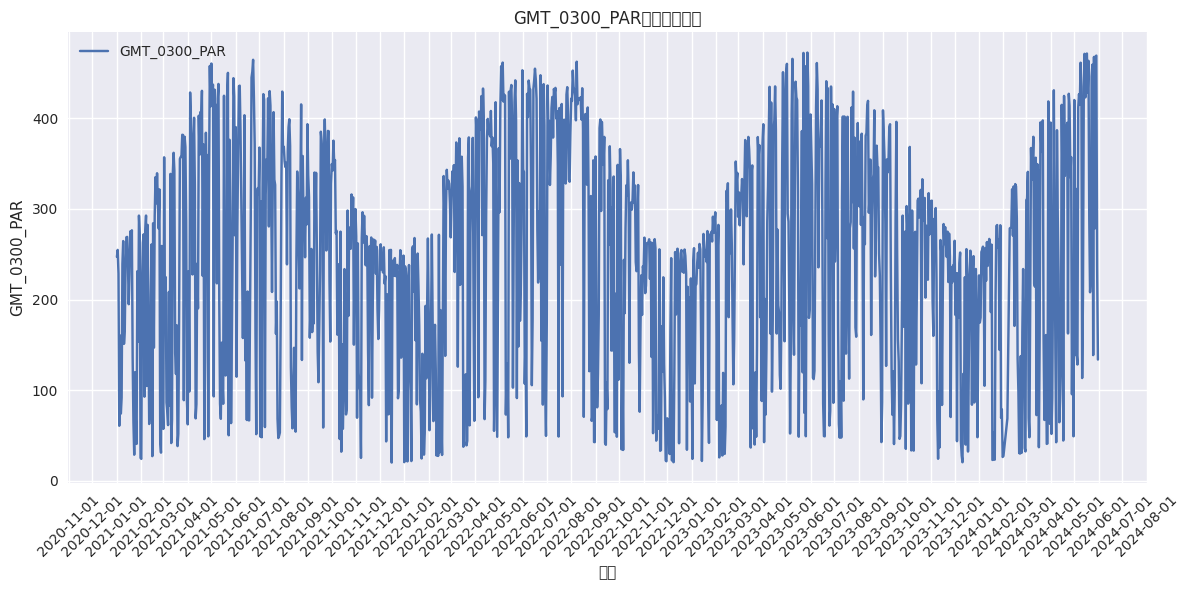

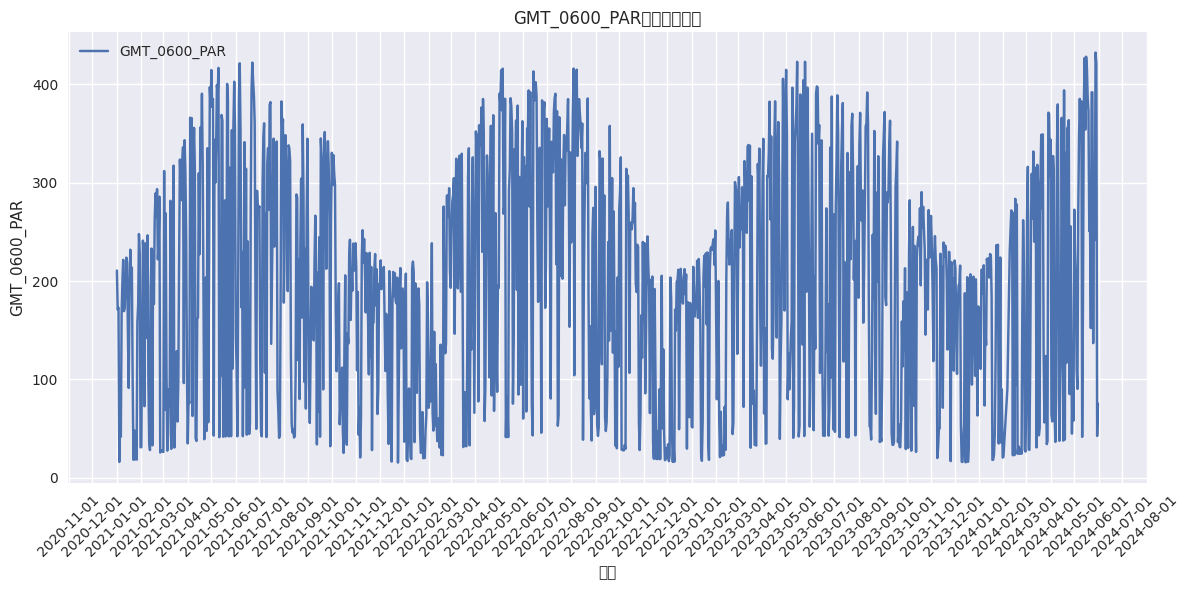

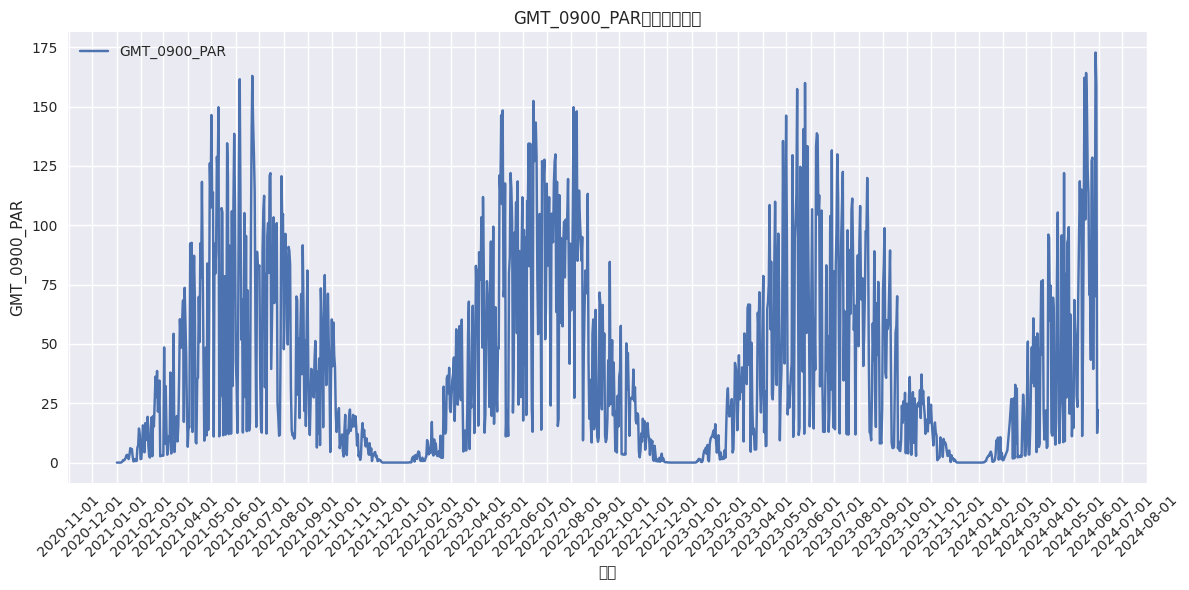

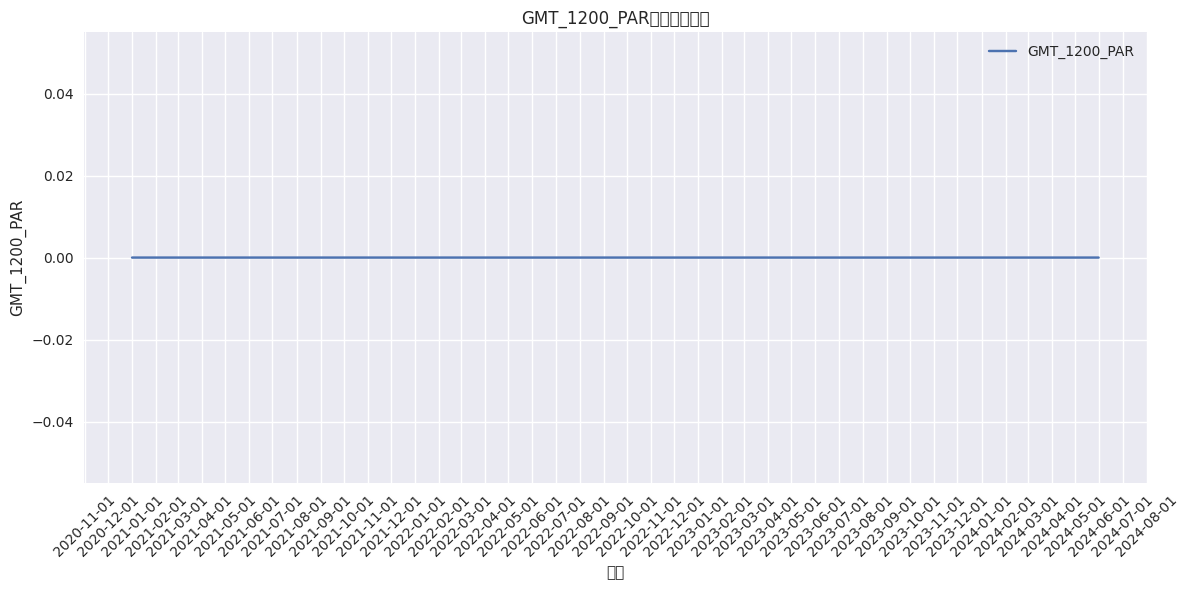

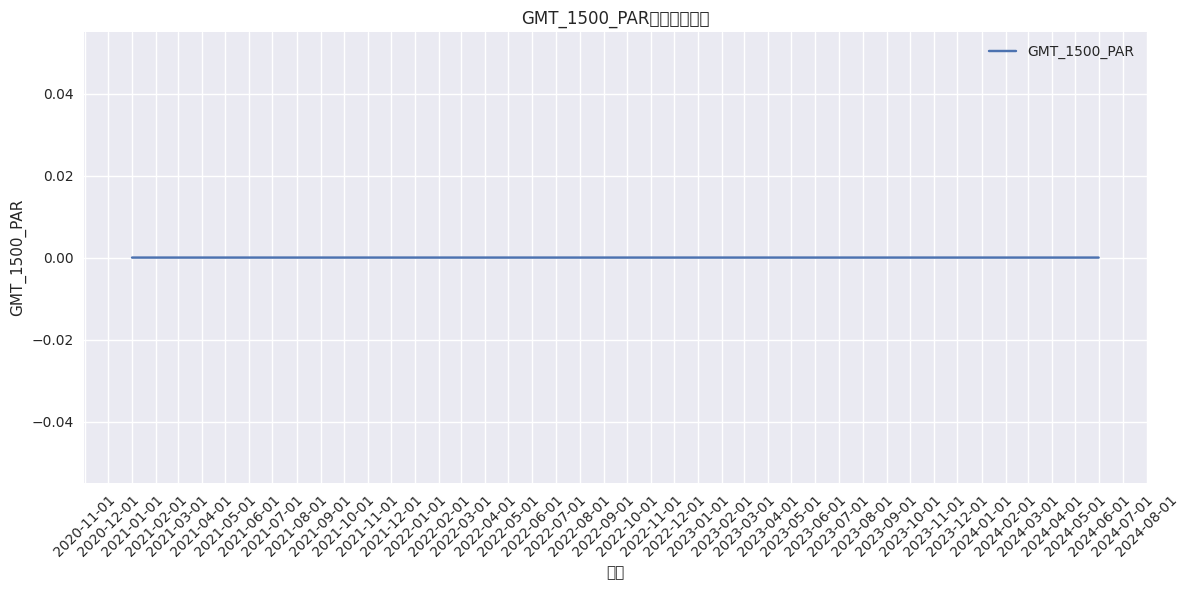

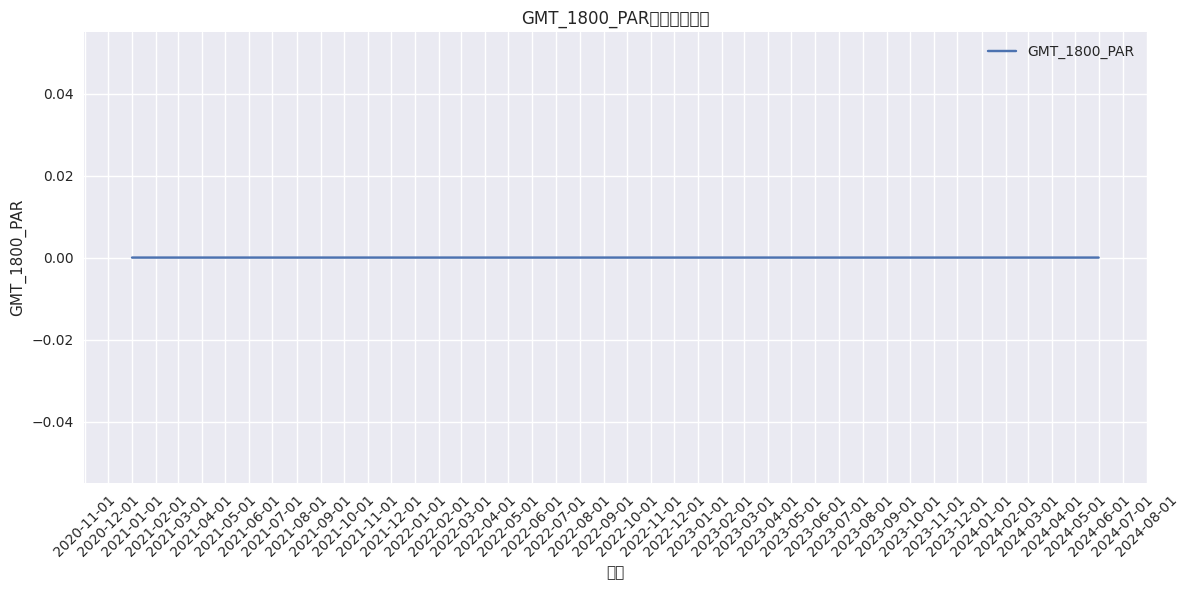

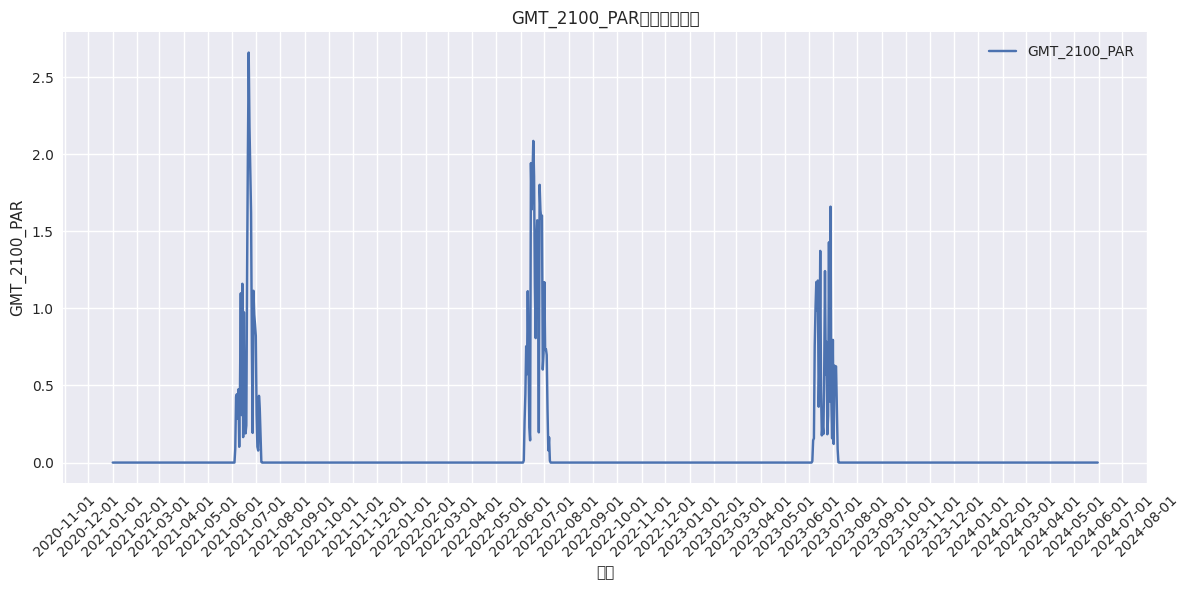

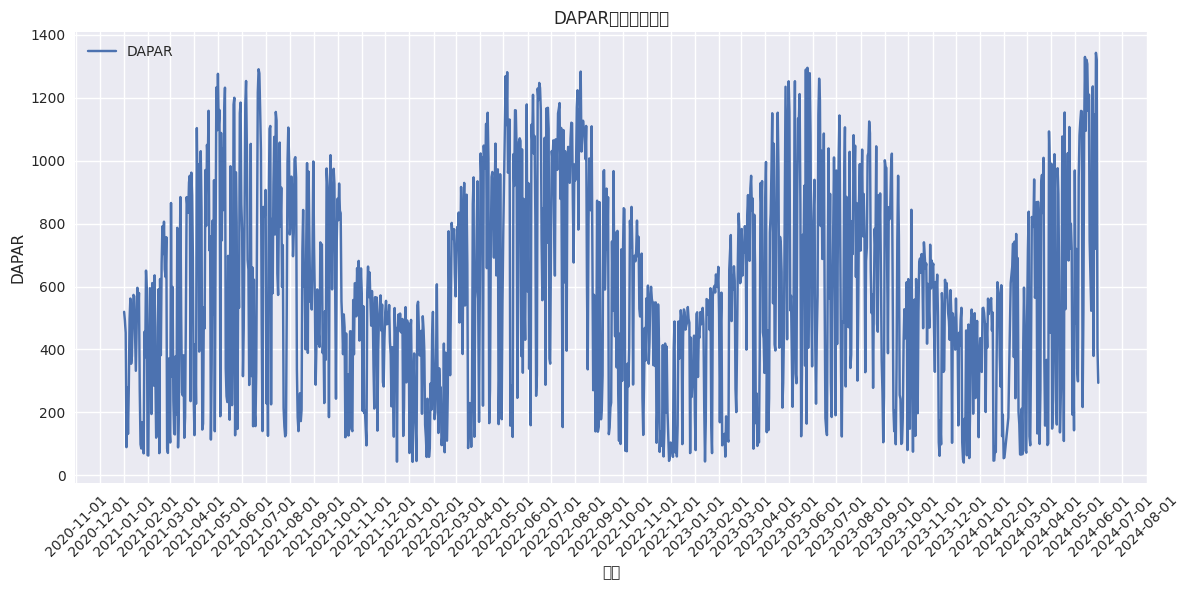

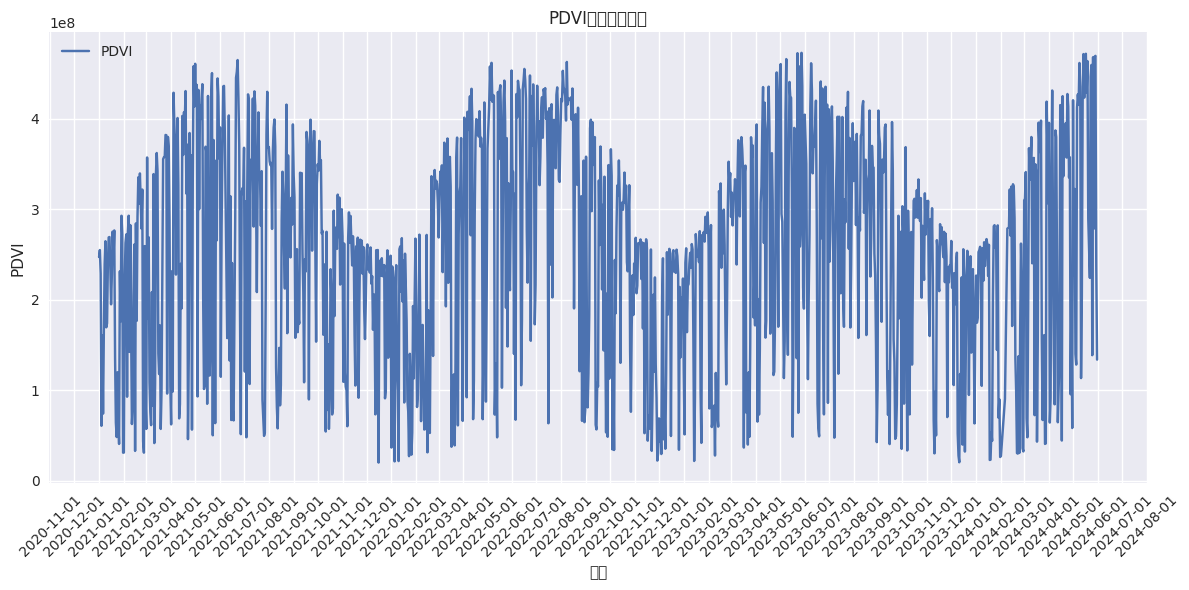

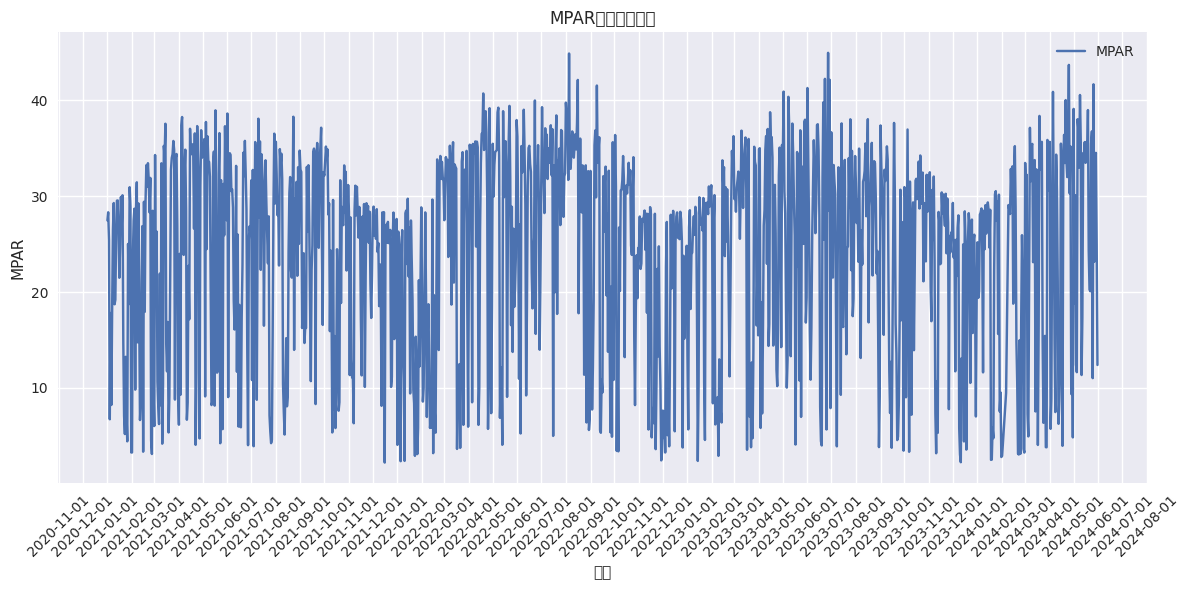

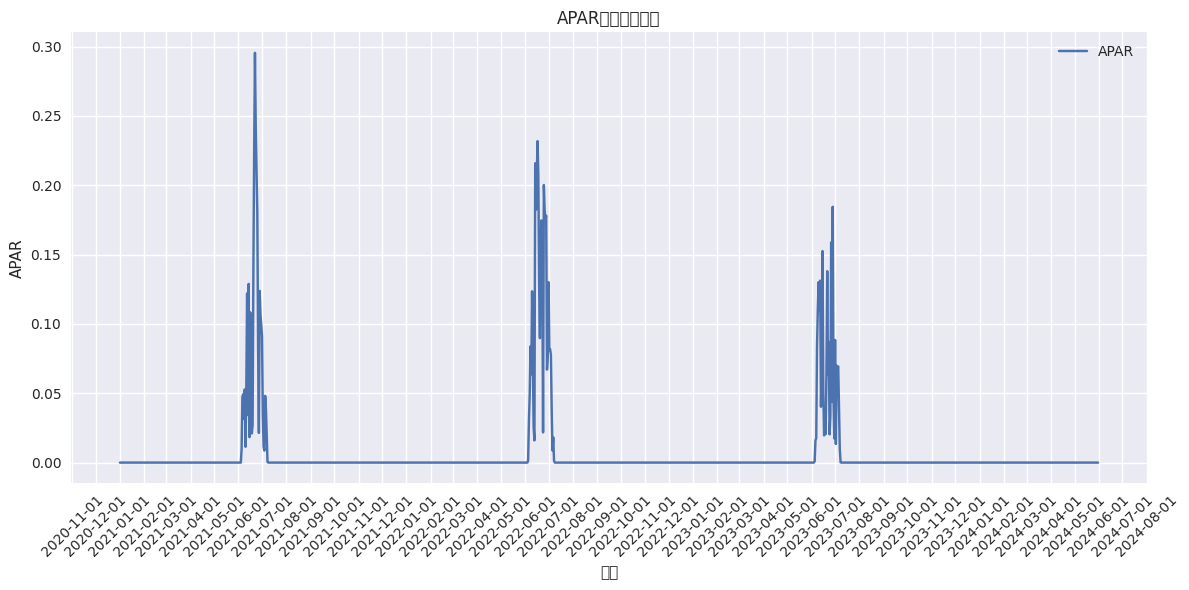

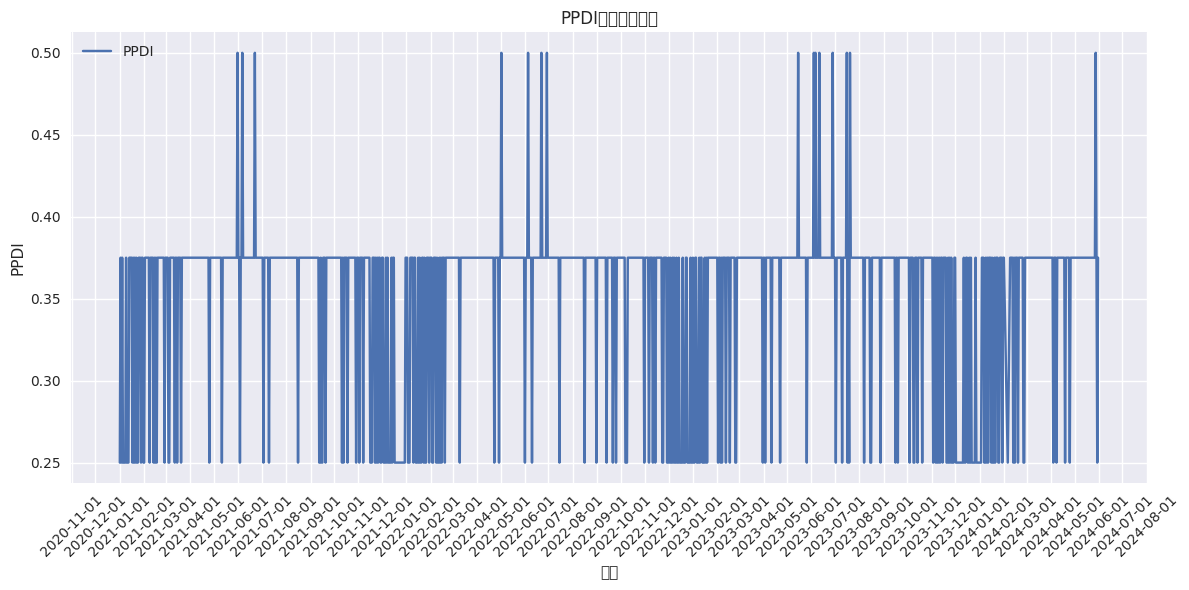

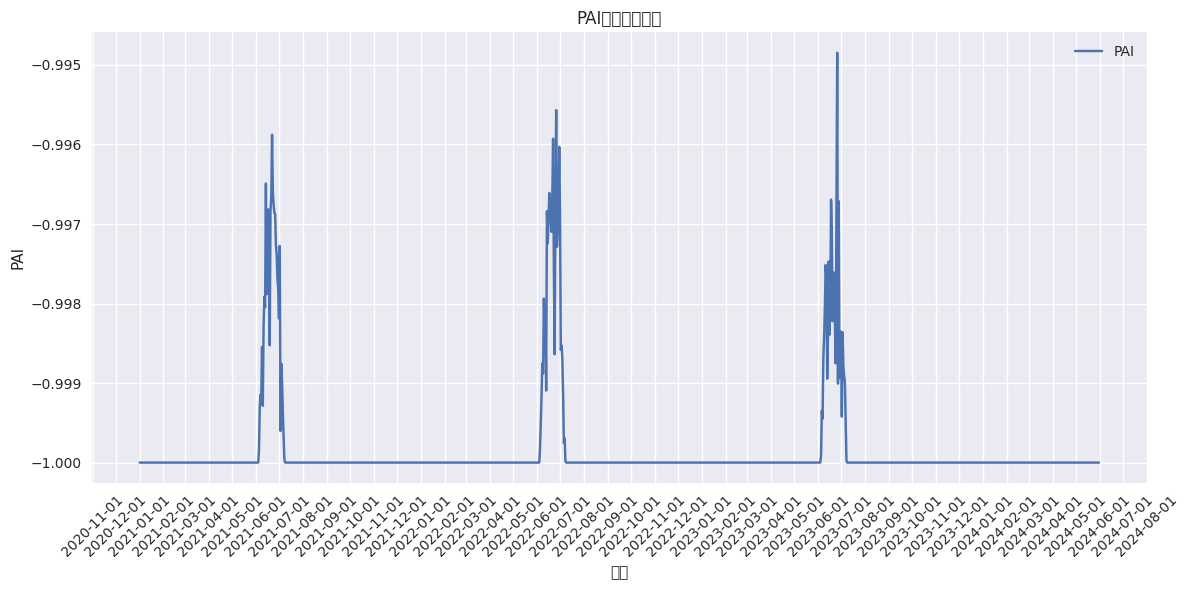

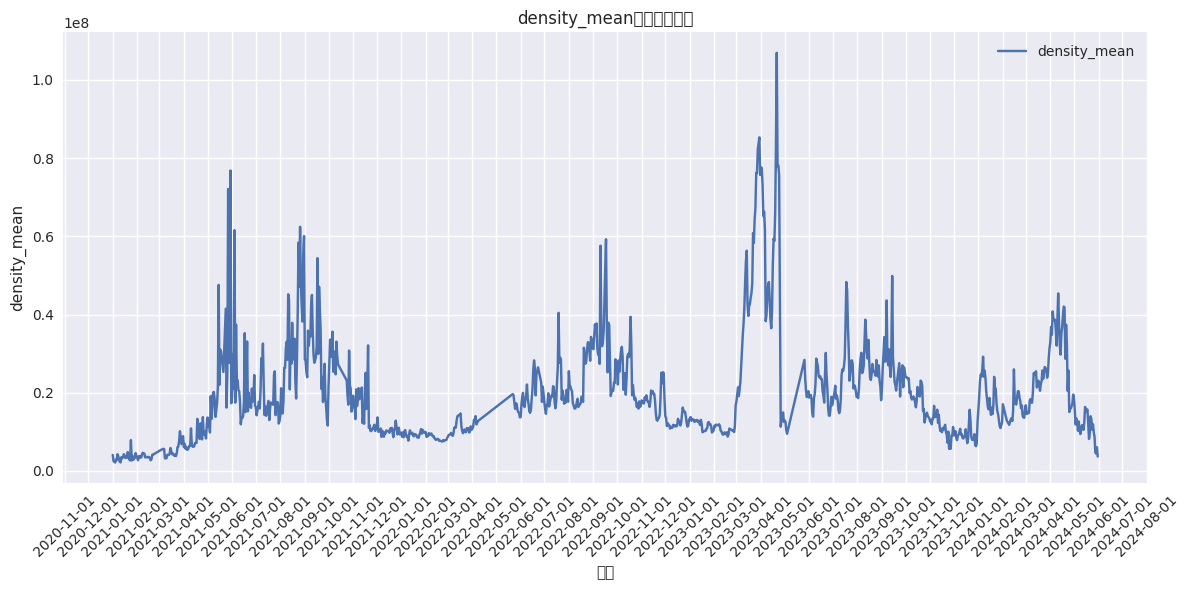

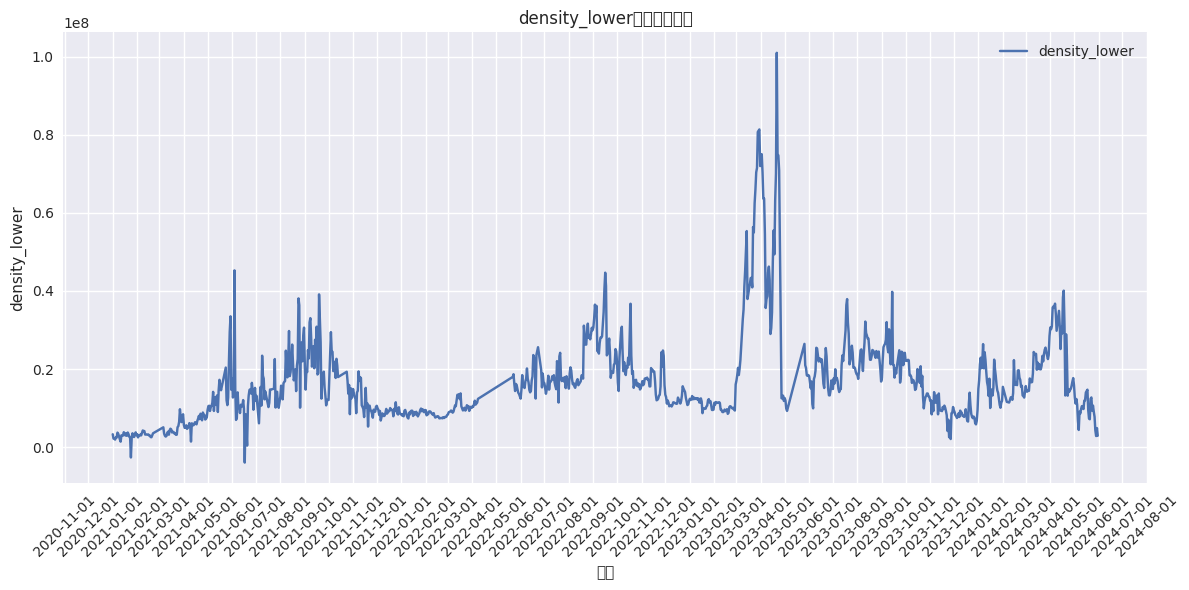

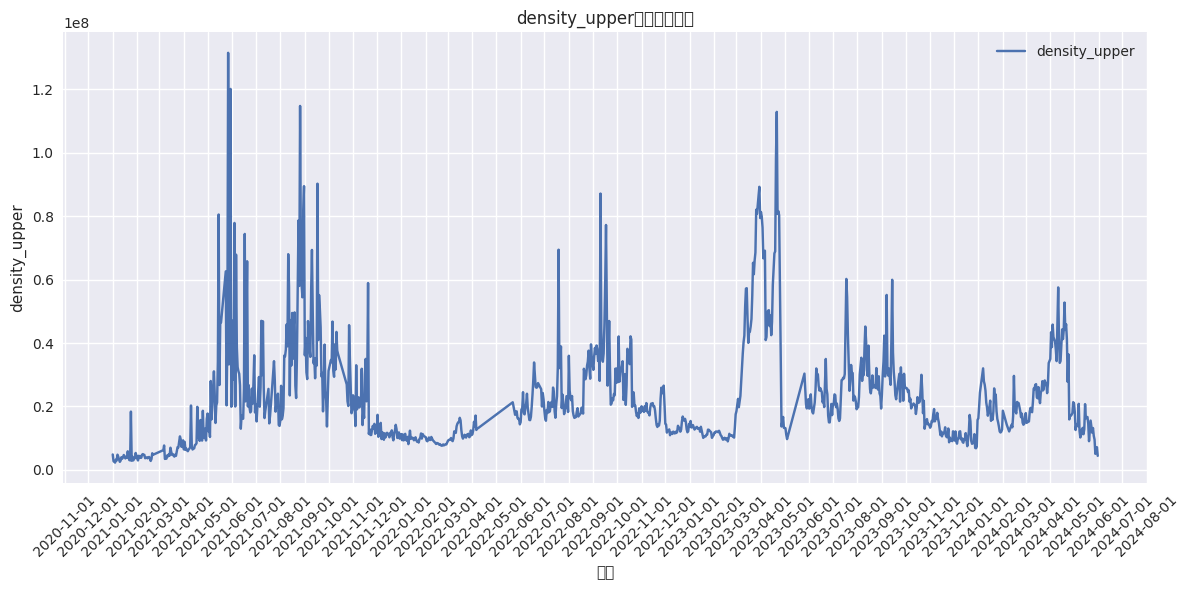

所有特征的时间序列图已生成完毕。


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# 获取当前工作目录
current_dir = os.getcwd()
print(f"当前工作目录: {current_dir}")

# 列出当前目录下的所有文件
files = os.listdir(current_dir)
print("当前目录下的文件:")
for file in files:
    print(file)

# 尝试读取CSV文件
try:
    df = pd.read_csv('特征和密度结果_MODIS_MCD18C2_061_20241104_插值填充_tuoshan.csv')
    print("成功读取CSV文件")
except FileNotFoundError:
    print("未找到CSV文件，请检查文件名和路径是否正确")
    raise

df['date'] = pd.to_datetime(df['date'])

# 获取所有特征列名
features = df.columns.drop(['date'])

# 设置图表样式
plt.style.use('seaborn')

# 为每个特征创建单独的图表
for feature in features:
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[feature], label=feature)
    plt.title(f'{feature}随时间的变化')
    plt.xlabel('日期')
    plt.ylabel(feature)
    plt.legend()
    
    # 设置x轴日期格式
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()





print("所有特征的时间序列图已生成完毕。")


# 保存LSTM模型

## 2024年

请你读取这个模型和数据，并进行预测，绘制结果图，并输出一些统计信息。这里的LSTM的时间窗口是10天，也就是说，我们使用历史10天的数据，进行LSTM的时间卷积处理，来预测第10天的密度。最后绘制2024年的对比图，包括实际数据和预测数据